In [46]:
import numpy as np

import matplotlib.pyplot as plt
from scipy import integrate
from scipy import linalg

import networkx as netx

import itertools

import random


N_sp = 50    ### Number of species

D = 1000   ### Diffusion coefficient

n_sp_full = []

habitats = np.array([(i+1)**2 for i in range(5)])   ## Number of patches

spatial_corr = 0           ## Spatial correlation between patches



## The function f(t,y) feeds into the ODE solver using a discretization of the Laplacian.
Note that low densities ($< 10^{-5}$) must be set to 0 before every step. This prevents exponential growth from resurrecting extinct species at a given patch. The only channel of rescue for that species comes from dispersal from other patches.

The dispersal contribution on a 2-dimensional grid is captured using the graph laplacian via the term:
```python
np.matmul(lap_mat, y.reshape((nx*ny,N_sp))).reshape(nx*ny*N_sp)
```

In [47]:
def f(t,y):
    
    y = np.asarray( [y[i] if y[i] > 10**-5 else 0 for i in range(len(y))] )
    
    return np.multiply(y,np.tile(r,nx*ny)  + np.dot( B ,y ) 
                       - np.dot( np.tile( r/K, nx*ny )*np.eye(N_sp*nx*ny), y ) ) + np.matmul(lap_mat, y.reshape((nx*ny,N_sp))).reshape(nx*ny*N_sp) 



## The routine below can be tweaked to incorporate different simulation settings.
Note: The standard deviation used below is above May's limit as in Fig. 2. Hence, the code takes longer to run than usual. Also, the spatial autocorrelation is 0. This can be easily changed through the spatial_corr variable in the first code cell. The a_rand variable below easily generates interaction matrices for different patches based on the covariance matrix  cov_mat.

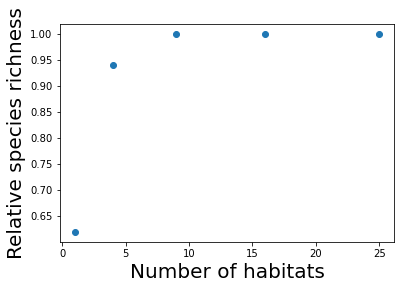

In [48]:
for ii in habitats:
    
    nx = int( np.sqrt(ii) )
    ny = nx
    
    ## create an undirected 2d grid graph. It is possible to use more complex graph types using the networkx library.
    G = netx.grid_2d_graph(nx,ny, periodic = True)   

    copyg = G.copy()

    for (a,b) in copyg.edges():
        copyg[a][b]['weight']= D

    #######  Convert networkx graph to graph laplacian ###
    
    lap_mat = - netx.laplacian_matrix(copyg, nodelist=None, weight='weight').toarray()
    
    #######################

    K = np.random.normal(1, 0.0, N_sp) 

    r = np.random.normal(1, 0.0, N_sp) 

        ####### Multiple interaction matrices for different patches ########
    
    patch_means = np.array([0 for i in range(ii)])  

    patch_std = (5/4)/np.sqrt(N_sp)

    G_lowcon = netx.erdos_renyi_graph(N_sp, 1, seed=None, directed=False) ## Can fix sparsity of interactions here
    
    A_sparse = netx.to_numpy_array(G_lowcon)
    
    cov_mat = np.array([ [patch_std**2 if i==j else (patch_std**2)*spatial_corr for j in range(ii)] for i in range(ii) ])

    rng = np.random.default_rng()
    
    a_rand = np.array([ rng.multivariate_normal(patch_means, cov_mat) if A_sparse[i//N_sp,i%N_sp]!=0 else np.zeros(nx*ny) for i in range(N_sp*N_sp) ])
    
    a_rand = np.reshape(a_rand.T,(N_sp,N_sp,nx*ny)).T


    B = np.array([ [ 0.0 if j==k or (k//N_sp != j//N_sp) else a_rand[j//(N_sp), j%N_sp, k%N_sp] for k in range(N_sp*nx*ny) ] for j in range(N_sp*nx*ny) ])
    
    
    sol = integrate.solve_ivp(f, [0,50], [ 1 for j in range(N_sp*nx*ny)] ) 
    
    n_sp_full.append( len( [sol.y[j, len(sol.t) - 1] for j in range(N_sp) if sol.y[j, len(sol.t) - 1] > 10**-5] ) )  ### All patches have the same number of species in spatially coherent limit
    

plt.scatter(habitats, np.asarray(n_sp_full)/N_sp)
            
plt.xlabel('Number of habitats', fontsize=20)
plt.ylabel('Relative species richness', fontsize=20)
plt.show()
    

    


## Varying the carrying capacities

In the following, we allow the carrying capacities to vary across species and check if spatial coherence still ensues.

In [37]:
##Spatial correlation

import numpy as np

import matplotlib.pyplot as plt
from scipy import integrate
from scipy import linalg

import networkx as netx

import itertools

import random
      

realize_degree = 1



N_sp = 50

nx = 4
ny = 4


habitats = np.array([nx*ny])   ## Effectively, all patches are distinct upto a spatial correlation

spatial_corr = 0           ## Spatial correlation between patches


## create an undirected 2d grid graph
G = netx.grid_2d_graph(nx,ny, periodic = True)   

copyg = G.copy()

for (a,b) in copyg.edges():
    copyg[a][b]['weight']= 1000
        
        
lap_mat = - netx.laplacian_matrix(copyg, nodelist=None, weight='weight').toarray()


def f(t,y):
    
    y = [y[i] if y[i] > 10**-5 else 0 for i in range(len(y))]
    
    y_diff = np.copy(y)

    diff_2d = np.matmul(lap_mat, y_diff.reshape((nx*ny,N_sp)))
    
    return np.multiply(y,np.tile(r,nx*ny)  + np.dot( B ,y ) - np.dot( np.tile( r/K, nx*ny )*np.eye(N_sp*nx*ny), y ) ) + diff_2d.reshape(nx*ny*N_sp) 


for ii in range(realize_degree):

    K = np.random.normal(3, 1, N_sp) 

    r = np.random.normal(1, 0.0, N_sp) 

        ####### Multiple interaction matrices for different patches ########
    
    patch_means = np.array([0 for i in range(habitats[ii])])  

    patch_std = 0.1

    G_lowcon = netx.erdos_renyi_graph(N_sp, 1, seed=None, directed=False)
    
    A_sparse = netx.to_numpy_array(G_lowcon)
    
    cov_mat = np.array([ [patch_std**2 if i==j else (patch_std**2)*spatial_corr for j in range(habitats[ii])] for i in range(habitats[ii]) ])

    rng = np.random.default_rng()
    
    a_rand = np.array([ rng.multivariate_normal(patch_means, cov_mat) if A_sparse[i//N_sp,i%N_sp]!=0 else np.zeros(nx*ny) for i in range(N_sp*N_sp) ])
    
    a_rand = np.reshape(a_rand.T,(N_sp,N_sp,nx*ny)).T


    B = np.array([ [ 0.0 if j==k or (k//N_sp != j//N_sp) else a_rand[j//(N_sp), j%N_sp, k%N_sp] for k in range(N_sp*nx*ny) ] for j in range(N_sp*nx*ny) ])
    
    
    sol2 = integrate.solve_ivp(f, [0,100], [ 0.5 for j in range(N_sp*nx*ny)] ) 
    
    ### Print indices of extinct species at different patches. Eg: For a pool of 50 species and 4 patches, index 1,51,101 and 151 represents the same species. 
    
    print( [ j for j in range(N_sp*nx*ny) if sol2.y[j, len(sol2.t) - 1] < 10**-5] )
    


(2, 2)
[2, 5, 15, 29, 52, 55, 65, 79, 102, 105, 115, 129, 152, 155, 165, 179, 202, 205, 215, 229, 252, 255, 265, 279, 302, 305, 315, 329, 352, 355, 365, 379, 402, 405, 415, 429, 452, 455, 465, 479, 502, 505, 515, 529, 552, 555, 565, 579, 602, 605, 615, 629, 652, 655, 665, 679, 702, 705, 715, 729, 752, 755, 765, 779]
[736]


In [38]:
sol2.y[50:100,len(sol2.t)-1]

array([2.56687970e+00, 3.92383072e+00, 7.20775801e-06, 2.09804168e+00,
       4.52309702e+00, 4.33527472e-06, 1.74689406e+00, 6.23562252e+00,
       1.85984579e+00, 1.85748403e+00, 4.16532561e-01, 3.07248833e+00,
       6.24581109e+00, 9.21091452e+00, 3.51253463e+00, 7.30886944e-06,
       3.42411092e+00, 6.52334993e+00, 1.73478226e+00, 3.12120453e+00,
       2.13944427e+00, 2.73775723e+00, 3.23027860e+00, 1.48156924e+00,
       1.69264340e+00, 2.19655409e+00, 4.05461302e+00, 6.27285506e+00,
       1.13647081e+00, 6.84639246e-07, 4.23039946e+00, 5.46734462e+00,
       2.18898675e+00, 1.04129931e+00, 3.05179253e+00, 4.18287052e+00,
       5.37466405e-01, 4.06682771e+00, 1.06153206e+00, 1.60493486e+00,
       1.14132960e+00, 9.93054757e-01, 2.43283549e-01, 1.60138687e+00,
       6.52595609e+00, 8.75514545e-01, 2.59148584e+00, 2.63199476e+00,
       3.75951317e+00, 4.70442628e-01])

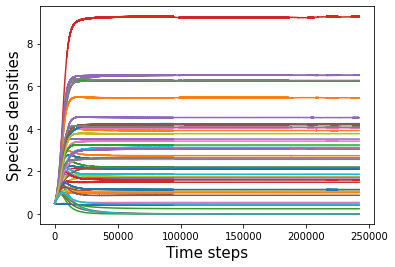

In [44]:
plt.plot(sol2.y[0:50].T)
plt.xlabel('Time steps', fontsize=15)
plt.ylabel('Species densities', fontsize=15)

plt.savefig('variable_K_patch1.eps', dpi=600, bbox_inches='tight')

plt.show()

### Function that feeds into the ODE solver for the averaged interaction matrix

In [40]:
def f_av(t,y):
    
    return np.multiply(y,r  + np.dot( B_av ,y**1 ) - np.dot( ( r/K )*np.eye(N_sp), y ) )


B_av = np.mean( np.array( [B[N_sp*i:N_sp*i+N_sp,N_sp*i:N_sp*i+N_sp] for i in range(nx*ny)] ), axis = 0 ) 

sol_av = integrate.solve_ivp(f_av, [0,1000], [ 0.5 for j in range(N_sp)] ) 







In [41]:
sol_av.y[:,len(sol_av.t) -1 ]

array([2.55784514e+000, 3.90606751e+000, 1.38005033e-129, 2.09584092e+000,
       4.52123061e+000, 4.26461984e-052, 1.74360896e+000, 6.22665879e+000,
       1.85988769e+000, 1.85992767e+000, 4.16364102e-001, 3.06880894e+000,
       6.23654558e+000, 9.21905014e+000, 3.51393051e+000, 3.55286774e-056,
       3.41756487e+000, 6.51620493e+000, 1.73337075e+000, 3.12189287e+000,
       2.14143765e+000, 2.73471434e+000, 3.22840518e+000, 1.48123057e+000,
       1.68995203e+000, 2.19092026e+000, 4.04373328e+000, 6.25971945e+000,
       1.13218968e+000, 1.89447300e-063, 4.23028131e+000, 5.45143287e+000,
       2.18574364e+000, 1.03907291e+000, 3.03874586e+000, 4.18203680e+000,
       5.37013079e-001, 4.06719202e+000, 1.05790644e+000, 1.60129036e+000,
       1.14301885e+000, 9.92989869e-001, 2.42444947e-001, 1.59577642e+000,
       6.51461359e+000, 8.73330225e-001, 2.58703503e+000, 2.62535920e+000,
       3.75744751e+000, 4.69947016e-001])

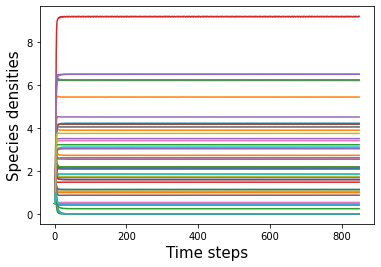

In [45]:
plt.plot( sol_av.y.T )
plt.xlabel('Time steps', fontsize=15)
plt.ylabel('Species densities', fontsize=15)

plt.savefig('variable_K_averaged_matrix.eps', dpi=600, bbox_inches='tight')

plt.show()

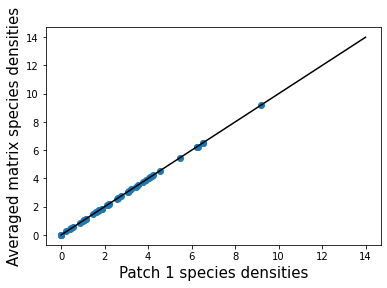

In [43]:
plt.plot(np.arange(15), np.arange(15), 'k-')
plt.scatter(sol2.y[50:100,len(sol2.t)-1], sol_av.y[:,len(sol_av.t) -1 ])
plt.xlabel('Patch 1 species densities', fontsize=15)
plt.ylabel('Averaged matrix species densities', fontsize=15)

plt.savefig('coherence_varying_K.eps', dpi=600, bbox_inches='tight')


### Varying dispersal rates across species

In [19]:
import numpy as np

import matplotlib.pyplot as plt
from scipy import integrate
from scipy import linalg

import networkx as netx

import itertools

import random
      

realize_degree = 1



N_sp = 50

nx = 4
ny = 4


habitats = np.array([nx*ny])   ## Effectively, all patches are distinct upto a spatial correlation

spatial_corr = 0           ## Spatial correlation between patches


## create an undirected 2d grid graph
G = netx.grid_2d_graph(nx,ny, periodic = True)
    

copyg = G.copy()


for (a,b) in copyg.edges():
    copyg[a][b]['weight']= 1
        
        
lap_mat = - netx.laplacian_matrix(copyg, nodelist=None, weight='weight').toarray()

D_i = np.random.normal(1000, 100, N_sp) ### Dispersal rates drawn from a distribution

def f(t,y):
    
    y = [y[i] if y[i] > 10**-5 else 0 for i in range(len(y))]
    
    y_diff = np.copy(y)

    diff_2d = np.matmul(lap_mat, D_i*y_diff.reshape((nx*ny,N_sp)))
    
    return np.multiply(y,np.tile(r,nx*ny)  + np.dot( B ,y ) - np.dot( np.tile( r/K, nx*ny )*np.eye(N_sp*nx*ny), y ) ) + diff_2d.reshape(nx*ny*N_sp) 


for ii in range(realize_degree):

    K = np.random.normal(3, 1, N_sp) 

    r = np.random.normal(1, 0.0, N_sp) 

        ####### Multiple interaction matrices for different patches ########
    
    patch_means = np.array([0 for i in range(habitats[ii])])  

    patch_std = 0.1

    G_lowcon = netx.erdos_renyi_graph(N_sp, 1, seed=None, directed=False)
    
    A_sparse = netx.to_numpy_array(G_lowcon)
    
    cov_mat = np.array([ [patch_std**2 if i==j else (patch_std**2)*spatial_corr for j in range(habitats[ii])] for i in range(habitats[ii]) ])

    rng = np.random.default_rng()
    
    
    a_rand = np.array([ rng.multivariate_normal(patch_means, cov_mat) if A_sparse[i//N_sp,i%N_sp]!=0 else np.zeros(nx*ny) for i in range(N_sp*N_sp) ])
    
    a_rand = np.reshape(a_rand.T,(N_sp,N_sp,nx*ny)).T

    

    B = np.array([ [ 0.0 if j==k or (k//N_sp != j//N_sp) else a_rand[j//(N_sp), j%N_sp, k%N_sp] for k in range(N_sp*nx*ny) ] for j in range(N_sp*nx*ny) ])
    
    
    sol2 = integrate.solve_ivp(f, [0,50], [ 0.5 for j in range(N_sp*nx*ny)] ) 

    ### Print indices of extinct species. Eg: For a pool of 50 species and 4 patches, index 1,51,101 and 151 represents the same species. 
    
    print( [ j for j in range(N_sp*nx*ny) if sol2.y[j, len(sol2.t) - 1] < 10**-5] )
    


(3, 0)
[20, 36, 70, 86, 120, 136, 170, 186, 220, 236, 270, 286, 320, 336, 370, 386, 420, 436, 470, 486, 520, 536, 570, 586, 620, 636, 670, 686, 720, 736, 770, 786]
[768]


In [20]:
sol2.y[50:100,len(sol2.t)-1]

array([3.37690095e+00, 7.64055653e-01, 2.95433826e+00, 1.31489321e+00,
       5.85852082e-01, 2.25950249e+00, 4.77041102e+00, 7.49882029e+00,
       1.95330400e+00, 1.90754189e+01, 5.72561795e+00, 4.13513561e+00,
       2.43016924e+00, 4.70088658e+00, 3.01837861e+00, 4.84284755e+00,
       5.03133382e+00, 5.63035077e+00, 2.97336502e+00, 3.43771027e+00,
       7.06644260e-06, 4.76391551e+00, 1.03925762e+01, 7.40507958e+00,
       7.51169971e+00, 2.74302525e+00, 8.73840815e+00, 6.59410743e-01,
       3.01034679e+00, 2.81134108e+00, 9.83713765e-01, 9.68277057e+00,
       3.84788689e+00, 2.21647562e+00, 1.41418523e+00, 2.51975991e-01,
       8.67939577e-06, 1.46973606e+00, 7.38046943e+00, 8.37503283e+00,
       5.28869343e+00, 8.91572057e+00, 1.68705526e-02, 3.41485786e+00,
       7.64544077e+00, 1.57603209e+00, 1.26467093e+00, 3.05312606e+00,
       2.83021462e+00, 5.72539925e+00])

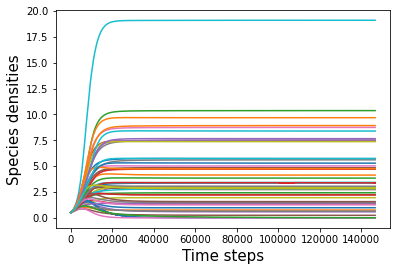

In [24]:
plt.plot(sol2.y[0:50].T)
plt.xlabel('Time steps', fontsize=15)
plt.ylabel('Species densities', fontsize=15)

plt.savefig('variable_K_and_D_patch1.eps', dpi=600, bbox_inches='tight')

plt.show()

In [22]:
def f_av(t,y):
    
    return np.multiply(y,r  + np.dot( B_av ,y**1 ) - np.dot( ( r/K )*np.eye(N_sp), y ) )


B_av = np.mean( np.array( [B[N_sp*i:N_sp*i+N_sp,N_sp*i:N_sp*i+N_sp] for i in range(nx*ny)] ), axis = 0 ) 

sol_av = integrate.solve_ivp(f_av, [0,1000], [ 0.5 for j in range(N_sp)] ) 

In [23]:
sol_av.y[:,len(sol_av.t) -1 ]

array([3.36752605e+000, 7.60456404e-001, 2.94021134e+000, 1.31028116e+000,
       5.83975933e-001, 2.26727517e+000, 4.76533184e+000, 7.48521642e+000,
       1.95162761e+000, 1.90038096e+001, 5.71672066e+000, 4.11488549e+000,
       2.43119287e+000, 4.68212676e+000, 3.01055109e+000, 4.82972429e+000,
       5.02290819e+000, 5.60003326e+000, 2.96225676e+000, 3.42370086e+000,
       1.30224119e-115, 4.74377530e+000, 1.03469765e+001, 7.36555359e+000,
       7.48698347e+000, 2.73790664e+000, 8.69764106e+000, 6.56965127e-001,
       2.99578960e+000, 2.80115249e+000, 9.87699501e-001, 9.63651281e+000,
       3.83407225e+000, 2.20947207e+000, 1.41216848e+000, 2.54177107e-001,
       2.51795369e-276, 1.46964091e+000, 7.34696267e+000, 8.35569337e+000,
       5.26953722e+000, 8.88930705e+000, 2.29506511e-022, 3.39105507e+000,
       7.62412552e+000, 1.56629259e+000, 1.25415993e+000, 3.04910554e+000,
       2.81836627e+000, 5.71017951e+000])

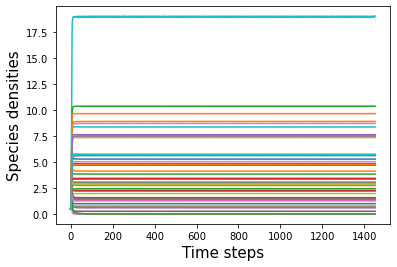

In [25]:
plt.plot(sol_av.y.T)
plt.xlabel('Time steps', fontsize=15)
plt.ylabel('Species densities', fontsize=15)

plt.savefig('variable_K_and_D_averaged_matrix.eps', dpi=600, bbox_inches='tight')

plt.show()

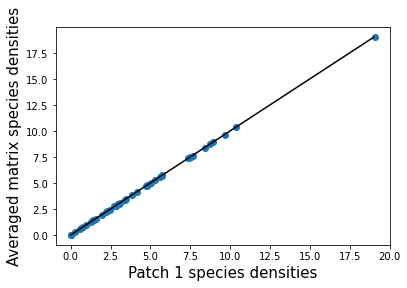

In [26]:
plt.plot(np.arange(20), np.arange(20), 'k-')
plt.scatter(sol2.y[0:50,len(sol2.t)-1], sol_av.y[:,len(sol_av.t) -1 ])
plt.xlabel('Patch 1 species densities', fontsize=15)
plt.ylabel('Averaged matrix species densities', fontsize=15)

plt.savefig('coherence_varying_K_and_D.eps', dpi=600, bbox_inches='tight')